In [1]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

### Load modules

In [2]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.4


# Import Data from Sheets or BigQuery

## From Sheets

In [3]:
#@title Parameters

#INPUT_SHEET_NAME = 'uncleaned data' #@param {type:"string"}

In [4]:
'''
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')
'''

"\nworksheet = gc.open(INPUT_SHEET_NAME).sheet1\n\n# get_all_values gives a list of rows.\nrows = worksheet.get_all_values()\n\ndf=pd.DataFrame.from_records(rows)\n\n\n#get column names from first row\ndf.columns = df.iloc[0]\n\n#drop row with column names\ndf = df.drop(df.index[0])\n\n#reset indexes\ndf = df.reset_index(drop=True)\n\n#convert numeric data to numeric types\ndf = df.apply(pd.to_numeric, errors='ignore')\n"

## From BigQuery

In [5]:
%%bigquery df
SELECT *
FROM `db.dataset.table`;

In [7]:
len(df.columns)

158

# Data Cleaning

Keep only necessary columns

In [8]:
df = df[['day','Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts']]
         

In [9]:
df.head()

,day,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
0,2019-03-25 00:00:00+00:00,17067,209733.00000,1735596.00000,334023.00000,1826161.00000,nan,5585,2653645.00000,3198766.00000,18284479.00000,nan,8400476.00000,1653
1,2018-11-29 00:00:00+00:00,13398,158747.00000,1270805.00000,801902.00000,272857.00000,nan,3807,7165284.00000,2144522.00000,4041579.00000,nan,2464305.00000,1466
2,2018-11-22 00:00:00+00:00,9109,103955.00000,1373478.00000,631746.00000,126028.00000,nan,2744,6705270.00000,2357421.00000,4331451.00000,nan,1292850.00000,604
3,2018-12-09 00:00:00+00:00,10787,166883.00000,1639503.00000,1522130.00000,287042.00000,nan,3111,9191794.00000,2792468.00000,3944924.00000,nan,2702506.00000,891
4,2019-03-30 00:00:00+00:00,12781,197307.00000,1369087.00000,341272.00000,1552542.00000,nan,4211,477541.00000,663885.00000,13782058.00000,nan,5689437.00000,1023


In [10]:
df.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
count,607.00000,395.00000,607.00000,537.00000,476.00000,150.00000,607.00000,607.00000,293.00000,567.00000,306.00000,572.00000,607.00000
mean,14329.43657,138307.91392,1467573.37562,474110.74674,478383.54832,90717.64667,6327.87644,2937961.65898,1767362.44710,4132429.98765,130004.89869,2057108.87413,1500.76277
std,2300.49043,123622.33399,481990.16535,654060.49468,439662.93621,77732.09721,2882.91855,2793634.29831,754953.49592,3812731.33632,84298.19283,2146889.03455,459.59147
min,7894.00000,6.00000,135172.00000,0.00000,0.00000,1.00000,2327.00000,139.00000,96.00000,0.00000,1.00000,8.00000,365.00000
25%,12746.00000,42645.50000,1323660.50000,27.00000,86555.75000,21510.00000,4073.00000,647711.50000,1329150.00000,2172631.00000,68846.00000,345110.25000,1174.00000
50%,14275.00000,106497.00000,1557938.00000,176869.00000,351108.50000,79376.00000,5298.00000,1611886.00000,1694250.00000,2895521.00000,117287.50000,1318603.00000,1478.00000
75%,15913.00000,194462.50000,1750653.50000,727563.00000,758465.75000,157358.50000,8145.00000,5092391.50000,2162229.00000,4644683.50000,196004.00000,2638520.00000,1697.00000
max,21552.00000,786651.00000,2433525.00000,2859646.00000,2889383.00000,319197.00000,16450.00000,10345069.00000,4003753.00000,20506222.00000,395993.00000,8800172.00000,3011.00000


In [11]:
df.sum()

Brand_x_Core_x_NC_clicks              8697968.00000   
The_Trade_Desk_x_Audio_x_AWA_imps     54631626.00000  
DBM_x_Display_x_RTG_imps              890817039.00000 
Amazon_x_Display_x_AWA_imps           254597471.00000 
DBM_x_Video_x_AWA_imps                227710569.00000 
The_Trade_Desk_x_Display_x_AWA_imps   13607647.00000  
Brand_x_RMKT_x_EC_clicks              3841021.00000   
OTHER_x_Display_x_AWA_imps            1783342727.00000
Amazon_x_Display_x_RTG_imps           517837197.00000 
DBM_x_Display_x_ACQ_imps              2343087803.00000
Oath_x_Display_x_AWA_imps             39781499.00000  
DBM_x_Display_x_AWA_imps              1176666276.00000
new_accounts                          910963.00000    
dtype: float64

## Step 1: Handling Missing Data

In [12]:
# Determine number of missing values
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

The_Trade_Desk_x_Display_x_AWA_imps   75.28830
Amazon_x_Display_x_RTG_imps           51.72982
Oath_x_Display_x_AWA_imps             49.58814
The_Trade_Desk_x_Audio_x_AWA_imps     34.92586
DBM_x_Video_x_AWA_imps                21.58155
Amazon_x_Display_x_AWA_imps           11.53213
DBM_x_Display_x_ACQ_imps              6.58979 
DBM_x_Display_x_AWA_imps              5.76606 
new_accounts                          0.00000 
OTHER_x_Display_x_AWA_imps            0.00000 
Brand_x_RMKT_x_EC_clicks              0.00000 
DBM_x_Display_x_RTG_imps              0.00000 
Brand_x_Core_x_NC_clicks              0.00000 
day                                   0.00000 
dtype: float64

In [13]:
# Determine percent of zeros by column
num_zeros = (100*df[df == 0].count(axis=0)/len(df.index))
num_zeros.sort_values(ascending = False)

DBM_x_Video_x_AWA_imps                1.31796
DBM_x_Display_x_ACQ_imps              0.16474
Amazon_x_Display_x_AWA_imps           0.16474
new_accounts                          0.00000
DBM_x_Display_x_AWA_imps              0.00000
Oath_x_Display_x_AWA_imps             0.00000
Amazon_x_Display_x_RTG_imps           0.00000
OTHER_x_Display_x_AWA_imps            0.00000
Brand_x_RMKT_x_EC_clicks              0.00000
The_Trade_Desk_x_Display_x_AWA_imps   0.00000
DBM_x_Display_x_RTG_imps              0.00000
The_Trade_Desk_x_Audio_x_AWA_imps     0.00000
Brand_x_Core_x_NC_clicks              0.00000
day                                   0.00000
dtype: float64

### Option to drop columns with high percentage of missing data

In [14]:
#@title Set threshold for missing data

remove_missing_vals = "No" #@param {type: "string"}
missing_value_threshold = 100 #@param {type:"integer"}


In [15]:
missing_value_threshold_cols = []

if remove_missing_vals == "Yes":
  for i in missing_values[missing_values >= missing_value_threshold].index:
    missing_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

No columns dropped
Remaining columns: Index(['day', 'Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps',
       'new_accounts'],
      dtype='object')


### Imputing Missing Data

In [16]:
#@title Define Imputation Method

# Imputation Method: Mean value, Median Value, Zero
imputation_method = 'Zero' #@param {type:"string"}


In [17]:
if imputation_method == 'mean value':
  df.fillna(df.mean(), inplace = True)
elif imputation_method == 'median value':
  df.fillna(df.median(), inplace = True)
else:
  df.fillna(0, inplace = True)


### Identify & drop columns with all 0's 


Constant variance violates model assumptions

The goal of printing the null_list below is to check alignment with the media buy.

In [18]:
# Identify columns with all 0's
col_nulls = df.loc[:, (df == 0).all()]
null_list = list(col_nulls.columns) 
null_list # check alignment with media buy 

# Drop columns with all 0's
df.drop(null_list, axis=1, inplace=True)
print("Columns dropped")

Columns dropped


## Step 2: Define date and Y (KPI column), create initial feature set

In [19]:
#@title Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

DATE_COL = "day" #@param {type: "string"}
KPI_COL = "new_accounts" #@param {type: "string"}


In [20]:
cols = [col for col in df.columns]
featureset_df = df[cols]
featureset_df = featureset_df.loc[:, (featureset_df != 0).any(axis=0)]

#Feature Selection

Note: A **max of 50 features** is recommended for 24 months of data due to risk of overfitting. 

1. **Step 1**: run correlation analysis & output pos/neg coefficients above specified threshold

2. **Step 2**: run variance inflation factor analysis & output results to flag multicollinearity above specified threshold 

3. checkpoint to update the INITIAL design of features if multicollinearity is an issue

4. **Step 3**: perform multivariate testing to FINALIZE feature selection / data reduction (see optional section below for advanced feature selection if you have more than 50 inputs)
 


## Step 1: Run correlation analysis & filter to positive coefficients > the specified threshold

In [21]:
#@title Input correlation threshold for output (must be between 0 and 1)

THRESHOLD_1 =  .6 #@param {type: "number"}

In [22]:
correl = df.corr()
correl

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
Brand_x_Core_x_NC_clicks,1.00000,-0.10349,0.07583,0.12557,0.09429,0.06766,0.44381,-0.10055,-0.07087,0.01486,0.15251,0.04467,0.68340
The_Trade_Desk_x_Audio_x_AWA_imps,-0.10349,1.00000,0.19381,-0.18746,0.36619,-0.19394,-0.50229,0.41651,0.65421,0.76126,-0.43545,0.78423,-0.18796
DBM_x_Display_x_RTG_imps,0.07583,0.19381,1.00000,0.12903,0.24075,-0.01182,-0.30652,0.16185,0.19630,0.15366,-0.00670,0.22074,0.25310
Amazon_x_Display_x_AWA_imps,0.12557,-0.18746,0.12903,1.00000,0.31030,-0.15333,0.00877,0.07212,0.11044,-0.11008,-0.10501,-0.04924,0.28682
DBM_x_Video_x_AWA_imps,0.09429,0.36619,0.24075,0.31030,1.00000,0.08002,-0.39212,0.28841,0.47235,0.57301,-0.30748,0.64754,0.24206
The_Trade_Desk_x_Display_x_AWA_imps,0.06766,-0.19394,-0.01182,-0.15333,0.08002,1.00000,0.04726,-0.23013,-0.33928,-0.13461,0.16247,-0.18353,0.31561
Brand_x_RMKT_x_EC_clicks,0.44381,-0.50229,-0.30652,0.00877,-0.39212,0.04726,1.00000,-0.51515,-0.60301,-0.36747,0.54729,-0.47622,0.12050
OTHER_x_Display_x_AWA_imps,-0.10055,0.41651,0.16185,0.07212,0.28841,-0.23013,-0.51515,1.00000,0.74263,0.43128,-0.49276,0.51041,-0.17060
Amazon_x_Display_x_RTG_imps,-0.07087,0.65421,0.19630,0.11044,0.47235,-0.33928,-0.60301,0.74263,1.00000,0.67899,-0.61677,0.71899,-0.13047
DBM_x_Display_x_ACQ_imps,0.01486,0.76126,0.15366,-0.11008,0.57301,-0.13461,-0.36747,0.43128,0.67899,1.00000,-0.38780,0.86056,-0.07472


In [23]:
# output correlations > threshold_1 to review for data reduction

corrs_pos = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_pos = corrs_pos[corrs_pos > THRESHOLD_1].stack().reset_index() # user defines threshold and can increase to be more conservative
corrs_pos = corrs_pos.loc[corrs_pos[0]<1.0]
corrs_pos

,level_0,level_1,0
1,Brand_x_Core_x_NC_clicks,new_accounts,0.68340
3,The_Trade_Desk_x_Audio_x_AWA_imps,Amazon_x_Display_x_RTG_imps,0.65421
4,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_ACQ_imps,0.76126
5,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_AWA_imps,0.78423
9,DBM_x_Video_x_AWA_imps,DBM_x_Display_x_AWA_imps,0.64754
13,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,0.74263
15,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,0.67899
16,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_AWA_imps,0.71899
18,DBM_x_Display_x_ACQ_imps,DBM_x_Display_x_AWA_imps,0.86056


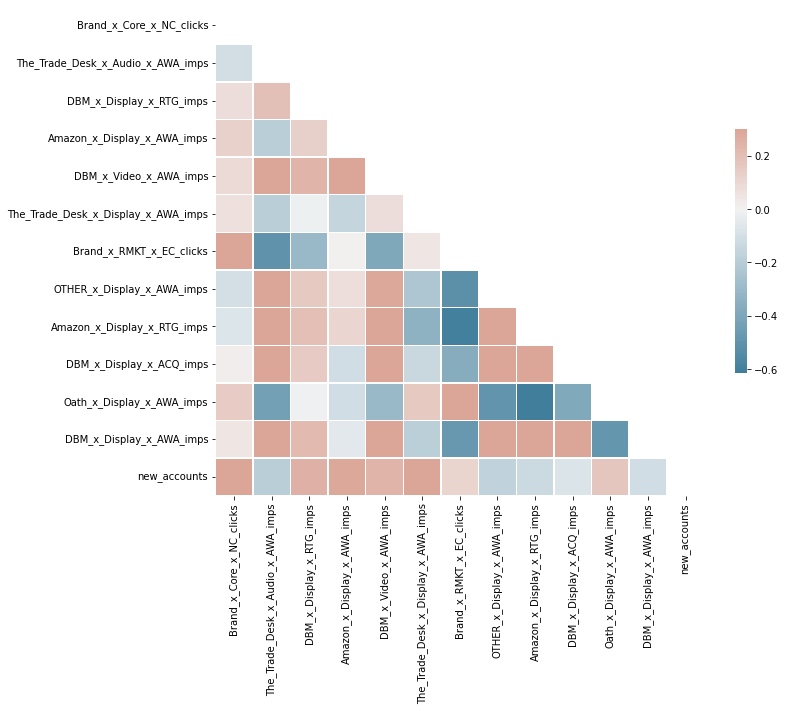

In [24]:
mask = np.triu(np.ones_like(correl, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correl, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
#@title Input 2nd correlation threshold (must be between -1 and 0)
THRESHOLD_2 =  -.6 #@param {type: "number"}

In [26]:
# feature reduction 1B: output correlations < threshold_2 to review for data reduction 
corrs_neg = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_neg = corrs_neg[corrs_neg < THRESHOLD_2].stack().reset_index() # user defines threshold and can decrease to be more conservative
corrs_neg = corrs_neg.loc[corrs_neg[0]<1.0]
corrs_neg

,level_0,level_1,0
0,Brand_x_RMKT_x_EC_clicks,Amazon_x_Display_x_RTG_imps,-0.60301
1,Amazon_x_Display_x_RTG_imps,Oath_x_Display_x_AWA_imps,-0.61677


## Step 2: Check for Multicollinearity


Run variance inflation factor (VIF) analysis & review values > 7 

Notes: 
*   Industry best practice flags values > 10 as a violation of regression model assumptions

In [27]:
featureset_df.head()

,day,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
0,2019-03-25 00:00:00+00:00,17067,209733.00000,1735596.00000,334023.00000,1826161.00000,0.00000,5585,2653645.00000,3198766.00000,18284479.00000,0.00000,8400476.00000,1653
1,2018-11-29 00:00:00+00:00,13398,158747.00000,1270805.00000,801902.00000,272857.00000,0.00000,3807,7165284.00000,2144522.00000,4041579.00000,0.00000,2464305.00000,1466
2,2018-11-22 00:00:00+00:00,9109,103955.00000,1373478.00000,631746.00000,126028.00000,0.00000,2744,6705270.00000,2357421.00000,4331451.00000,0.00000,1292850.00000,604
3,2018-12-09 00:00:00+00:00,10787,166883.00000,1639503.00000,1522130.00000,287042.00000,0.00000,3111,9191794.00000,2792468.00000,3944924.00000,0.00000,2702506.00000,891
4,2019-03-30 00:00:00+00:00,12781,197307.00000,1369087.00000,341272.00000,1552542.00000,0.00000,4211,477541.00000,663885.00000,13782058.00000,0.00000,5689437.00000,1023


In [28]:
vif = add_constant(featureset_df.drop(columns=[DATE_COL, KPI_COL]))

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 
print(vif.sort_values(ascending=False))

const                                 52.58583
DBM_x_Display_x_AWA_imps              6.94339 
Amazon_x_Display_x_RTG_imps           5.24322 
DBM_x_Display_x_ACQ_imps              5.07682 
The_Trade_Desk_x_Audio_x_AWA_imps     3.68820 
Brand_x_RMKT_x_EC_clicks              3.25918 
DBM_x_Video_x_AWA_imps                2.98071 
OTHER_x_Display_x_AWA_imps            2.43357 
Oath_x_Display_x_AWA_imps             1.94597 
Brand_x_Core_x_NC_clicks              1.61694 
Amazon_x_Display_x_AWA_imps           1.61254 
The_Trade_Desk_x_Display_x_AWA_imps   1.42645 
DBM_x_Display_x_RTG_imps              1.29527 
dtype: float64


In [29]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [30]:
vif_df

,feature,vif
0,const,52.58583
12,DBM_x_Display_x_AWA_imps,6.94339
9,Amazon_x_Display_x_RTG_imps,5.24322
10,DBM_x_Display_x_ACQ_imps,5.07682
2,The_Trade_Desk_x_Audio_x_AWA_imps,3.68820
7,Brand_x_RMKT_x_EC_clicks,3.25918
5,DBM_x_Video_x_AWA_imps,2.98071
8,OTHER_x_Display_x_AWA_imps,2.43357
11,Oath_x_Display_x_AWA_imps,1.94597
1,Brand_x_Core_x_NC_clicks,1.61694


In [31]:
#vif_df = vif_df[vif_df['feature']!='const']
#vif_df[vif_df['vif'] >= 5].feature.tolist()

In [32]:
#featureset_df = featureset_df.drop(columns = vif_df[vif_df['vif'] >= 5].feature.tolist())
#featureset_df.columns

## Step 3: Feature Transformation

Options:
* SQRT 
* Log
* De-Mean
* In previous tests, application of SQRT function outperformed log


In [33]:
#@title Input transformation type (ex: log, sqrt)
transformation = 'None' #@param ["Square Root", "Mean","Log","Natural Log","None"]

In [34]:
X = featureset_df.drop(columns=[DATE_COL,KPI_COL])

# These transformations stabilize large values in the dataset, and allow the data to be more normal
if transformation == "Square Root":
  X_transform = X.apply(np.sqrt)
elif transformation == "Mean":
  X_transform = X/X.mean()
elif transformation == "Natural Log": 
  X += 1 # natural log function is not defined at 0 so need to add 1 to each value 
  X_transform = X.apply(np.log)
else:
  X_transform = X

In [35]:
X_transform.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps
0,17067,209733.00000,1735596.00000,334023.00000,1826161.00000,0.00000,5585,2653645.00000,3198766.00000,18284479.00000,0.00000,8400476.00000
1,13398,158747.00000,1270805.00000,801902.00000,272857.00000,0.00000,3807,7165284.00000,2144522.00000,4041579.00000,0.00000,2464305.00000
2,9109,103955.00000,1373478.00000,631746.00000,126028.00000,0.00000,2744,6705270.00000,2357421.00000,4331451.00000,0.00000,1292850.00000
3,10787,166883.00000,1639503.00000,1522130.00000,287042.00000,0.00000,3111,9191794.00000,2792468.00000,3944924.00000,0.00000,2702506.00000
4,12781,197307.00000,1369087.00000,341272.00000,1552542.00000,0.00000,4211,477541.00000,663885.00000,13782058.00000,0.00000,5689437.00000


In [36]:
X_transform.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,14329.43657,90002.67875,1467573.37562,419435.70181,375140.97035,22417.86985,6327.87644,2937961.65898,853109.05601,3860111.70181,65537.88962,1938494.68863
std,2300.49043,119544.59266,481990.16535,633522.18596,436246.71971,54948.20265,2882.91855,2793634.29831,1027558.55465,3824957.66960,88365.99537,2138513.71255
min,7894.00000,0.00000,135172.00000,0.00000,0.00000,0.00000,2327.00000,139.00000,0.00000,0.00000,0.00000,0.00000
25%,12746.00000,0.00000,1323660.50000,6.00000,3.00000,0.00000,4073.00000,647711.50000,0.00000,2027536.50000,0.00000,313889.00000
50%,14275.00000,42017.00000,1557938.00000,98193.00000,240777.00000,0.00000,5298.00000,1611886.00000,0.00000,2783977.00000,1.00000,1202255.00000
75%,15913.00000,154324.00000,1750653.50000,682694.50000,646051.00000,0.00000,8145.00000,5092391.50000,1666294.50000,4409461.50000,117787.00000,2465588.50000
max,21552.00000,786651.00000,2433525.00000,2859646.00000,2889383.00000,319197.00000,16450.00000,10345069.00000,4003753.00000,20506222.00000,395993.00000,8800172.00000


### Standardize Features

Puts data on the same scale and optimizes performance and interpretability

In [37]:
standardize_features = "Yes" #@param {type: "string"}


In [38]:
if standardize_features == "No":
  X_transform_stand = X_transform
elif standardize_features == "Yes":
  #scaler = StandardScaler()
  scaler = MinMaxScaler()
  #standardized_transform = scaler.fit_transform(X_transform)
  standardized_transform = MinMaxScaler().fit_transform(X_transform)
  X_transform_stand = pd.DataFrame(standardized_transform, columns = X.columns)
else:
  X_transform_stand = X_transform

In [39]:
X_transform_stand.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps'],
      dtype='object')

###Run regression results to review p-values for data reduction only

In [40]:
# add column of 1's to estimate intercept parameter
X_transform_stand = sm.add_constant(X_transform_stand) 

# define Y
Y = featureset_df[[KPI_COL]]

# run OLS model using statsmodels package for p-values
model = sm.OLS(Y, X_transform_stand)
results = model.fit()
predictions = model.predict(results.params) 

print_model = results.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           new_accounts   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     158.3
Date:                Wed, 22 Sep 2021   Prob (F-statistic):          4.86e-176
Time:                        19:59:15   Log-Likelihood:                -4146.5
No. Observations:                 607   AIC:                             8319.
Df Residuals:                     594   BIC:                             8376.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 611.8056     43.665     14.011      0.000     526.049     697.562
Brand_x_Core_x_NC_clicks             2242.3324     69.485     32.271      0.000    2105.866    2378.799
The_Trade_Desk_x_Audio_x_AWA_imps      30.8676    116.315      0.265      0.791    -197.572     259.307
DBM_x_Display_x_RTG_imps              215.9317     49.950      4.323      0.000     117.831     314.032
Amazon_x_Display_x_AWA_imps           340.3548     52.757      6.451      0.000     236.741     443.969
DBM_x_Video_x_AWA_imps                614.2961    105.247      5.837      0.000     407.594     820.998
The_Trade_Desk_x_Display_x_AWA_imps   434.4785     63.857      6.804      0.000     309.065     559.892
Brand_x_RMKT_x_EC_clicks            -1023.9144     81.400    -12.579      0.000   -1183.782    -864.047
OTHER_x_Display_x_AWA_imps           -177.1225     53.169     -3.331      0.001    -281.545     -72.700
Amazon_x_Display_x_RTG_imps          -132.5752     82.118     -1.614      0.107    -293.852      28.702
DBM_x_Display_x_ACQ_imps              644.9301    111.182      5.801      0.000     426.573     863.287
Oath_x_Display_x_AWA_imps             163.9196     57.537      2.849      0.005      50.919     276.921
DBM_x_Display_x_AWA_imps            -1073.2664     99.803    -10.754      0.000   -1269.276    -877.257
==============================================================================
Omnibus:                       11.832   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.165
Skew:                          -0.212   Prob(JB):                     0.000509
Kurtosis:                       3.648   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Implement FINAL feature selection logic based on analysis of above results

Set your p-Value threshold. This removes features with P values greater than the threshold below. For example: 
*   p-Value <= .1 / 90% significance 

In [41]:
#@title Input p-Value threshold
P_THRESHOLD =  .1 #@param {type: "number"}

In [42]:
# FINAL feature selection/data reduction
results_df = (results.summary2().tables[1])
sig_input = list(results_df[results_df['P>|t|']<=P_THRESHOLD].index)[1:]
#X_inputs = X_transform_stand[sig_input] 
X_inputs = X_transform_stand
X_inputs.columns


Index(['const', 'Brand_x_Core_x_NC_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Video_x_AWA_imps',
       'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks',
       'OTHER_x_Display_x_AWA_imps', 'Amazon_x_Display_x_RTG_imps',
       'DBM_x_Display_x_ACQ_imps', 'Oath_x_Display_x_AWA_imps',
       'DBM_x_Display_x_AWA_imps'],
      dtype='object')

## Steps 4 & 5 Reduce Feature Set (Optional)

Feature selection methods if > 50 inputs remain after 3-step data reduction process

In [43]:
X_inputs.describe()

,const,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,1.00000,0.47118,0.11441,0.57972,0.14667,0.12983,0.07023,0.28329,0.28399,0.21308,0.18824,0.16550,0.22028
std,0.00000,0.16844,0.15197,0.20971,0.22154,0.15098,0.17215,0.20413,0.27005,0.25665,0.18653,0.22315,0.24301
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,0.35525,0.00000,0.51710,0.00000,0.00000,0.00000,0.12363,0.06260,0.00000,0.09887,0.00000,0.03567
50%,1.00000,0.46720,0.05341,0.61904,0.03434,0.08333,0.00000,0.21037,0.15580,0.00000,0.13576,0.00000,0.13662
75%,1.00000,0.58713,0.19618,0.70289,0.23873,0.22359,0.00000,0.41195,0.49225,0.41618,0.21503,0.29745,0.28018
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [44]:
len(X_inputs.columns)

13

###Step 4: KBest

Top features based on univariate testing


In [45]:
k_best = SelectKBest(f_regression, k=len(X_inputs.columns))
k_best.fit_transform(X_inputs, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


array([[1.00000000e+00, 6.71621028e-01, 2.66615055e-01, ...,
        8.91655177e-01, 0.00000000e+00, 9.54580888e-01],
       [1.00000000e+00, 4.02987260e-01, 2.01801053e-01, ...,
        1.97090376e-01, 0.00000000e+00, 2.80029186e-01],
       [1.00000000e+00, 8.89588520e-02, 1.32148818e-01, ...,
        2.11226183e-01, 0.00000000e+00, 1.46911901e-01],
       ...,
       [1.00000000e+00, 5.07687802e-01, 0.00000000e+00, ...,
        1.74856051e-01, 3.01232598e-01, 0.00000000e+00],
       [1.00000000e+00, 6.12241910e-01, 0.00000000e+00, ...,
        1.30444262e-01, 3.25553735e-01, 2.55990451e-02],
       [1.00000000e+00, 5.83467565e-01, 0.00000000e+00, ...,
        1.54929562e-01, 4.00906077e-01, 9.09073141e-07]])

###Step 5: Recursive Feature Elimination (RFE)

Rank features based on recursive model testing

In [46]:
lm = LinearRegression()
rfe = RFE(lm, 1)
X_rfe = rfe.fit_transform(X_inputs,Y)
lm.fit(X_rfe,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Output results of optional feature selection process

In [47]:
# create dataframe with KBest and RFE results
opt_datared_df = pd.DataFrame({'feature': X_inputs.columns, 'p_value': k_best.pvalues_, 'rfe_rank': rfe.ranking_}).sort_values('p_value')
opt_datared_df

,feature,p_value,rfe_rank
1,Brand_x_Core_x_NC_clicks,0.00000,1
6,The_Trade_Desk_x_Display_x_AWA_imps,0.00000,6
4,Amazon_x_Display_x_AWA_imps,0.00000,8
3,DBM_x_Display_x_RTG_imps,0.00000,7
5,DBM_x_Video_x_AWA_imps,0.00000,2
2,The_Trade_Desk_x_Audio_x_AWA_imps,0.00000,12
8,OTHER_x_Display_x_AWA_imps,0.00002,9
11,Oath_x_Display_x_AWA_imps,0.00003,10
9,Amazon_x_Display_x_RTG_imps,0.00127,11
7,Brand_x_RMKT_x_EC_clicks,0.00294,4


#### Implement OPTIONAL feature selection logic based on analysis of above results
Set your p-Value threshold. For example: 
*   p-Value <= .1 / 90% significance OR
*   top 75%+ of ranking (e.g. top 15 of total 20)


In [48]:
#@title Input p-Value and rank thresholds
P_THRESHOLD_OPT =  .1 #@param {type: "number"}
RANK_THRESHOLD =  1 #@param {type: "number"}

In [49]:
# OPTIONAL feature selection/data reduction

opt_reduction = opt_datared_df[((opt_datared_df['p_value']<=P_THRESHOLD_OPT) | 
                             (opt_datared_df['rfe_rank'] <= RANK_THRESHOLD))] 

In [50]:
# create list of FINAL model inputs, overwriting previous input feature list.
opt_inputs =[]   

for index, rows in opt_reduction.iterrows(): # iterate over each row 
    opt_inputs.append(rows.feature) 

X_inputs = X_inputs[opt_inputs]

# Compile Final Dataset

In [51]:
data = X_inputs
data[KPI_COL] = Y
data.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,DBM_x_Display_x_ACQ_imps,new_accounts
0,0.67162,0.00000,0.11681,0.69634,0.63202,0.26662,0.25650,0.00000,0.79894,0.23069,0.95458,0.89166,1653
1,0.40299,0.00000,0.28042,0.49411,0.09443,0.20180,0.69262,0.00000,0.53563,0.10479,0.28003,0.19709,1466
2,0.08896,0.00000,0.22092,0.53878,0.04362,0.13215,0.64816,0.00000,0.58880,0.02953,0.14691,0.21123,604
3,0.21182,0.00000,0.53228,0.65453,0.09934,0.21214,0.88852,0.00000,0.69746,0.05551,0.30710,0.19238,891
4,0.35781,0.00000,0.11934,0.53687,0.53733,0.25082,0.04615,0.00000,0.16582,0.13340,0.64651,0.67209,1023


# Visualize Target Variable and Features

In [52]:
len(data.columns)

13

In [53]:
data.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'OTHER_x_Display_x_AWA_imps', 'Oath_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'DBM_x_Display_x_ACQ_imps', 'new_accounts'],
      dtype='object')

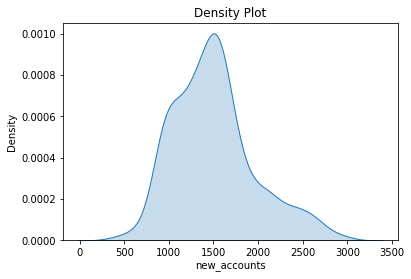

In [54]:
sns.kdeplot(data[KPI_COL], label = KPI_COL, shade = True)
plt.xlabel(KPI_COL); plt.ylabel('Density'); plt.title('Density Plot');

Plot some features

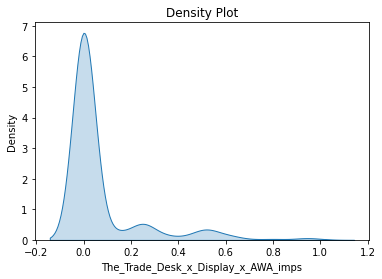

In [55]:
sns.kdeplot(data[data.columns[1]], label = '', shade = True)
plt.xlabel(data.columns[1]); plt.ylabel('Density'); plt.title('Density Plot');

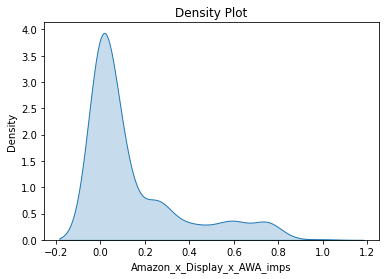

In [56]:
sns.kdeplot(data[data.columns[2]], label = '', shade = True)
plt.xlabel(data.columns[2]); plt.ylabel('Density'); plt.title('Density Plot');

Look at relationship of individual features with target data

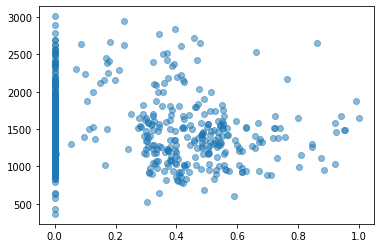

In [57]:
plt.plot(data[data.columns[8]], data['new_accounts'],'o',alpha=0.5)
plt.show()

In [58]:
#@title Name data export sheet

# Naming for final data export
SHEET_NAME = 'model input data' #@param {type:"string"}
TAB_NAME = 'results' #@param {type:"string"}

In [59]:
# create new spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.create(SHEET_NAME)

# generate link for file 
SHEET_URL = "https://docs.google.com/spreadsheets/d/"+sh.id
print("Sheet URL is " + SHEET_URL)

Sheet URL is https://docs.google.com/spreadsheets/d/1c-mzh4UjYJXBzZSnUS4BKE2MncIO1dH4OGlH7CTGAo4


In [60]:
worksheet = sh.add_worksheet(title= TAB_NAME, rows=len(data), cols=len(data.columns))
set_with_dataframe(worksheet, data)